# Packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat
from scipy.interpolate import interp2d, NearestNDInterpolator

<H1>Read SST data and make my own work -> find the CP-CA trancate SST</H1>

In [2]:
import os
os.getcwd()

%cd /g/data/p66/ars599/work_rp2/

/g/data/p66/ars599/work_rp2


# Functions and constants

In [3]:
import numpy as np
from scipy.interpolate import interp2d

# try to find a angle of the map and output the transect data -> PMM 
def get_transect(angle,npoints,x,y,z):
    transect_length  = np.min((np.max(y)-np.min(y),np.max(x)-np.min(x)))
    transect_pointss = np.linspace(-transect_length/2,transect_length/2,npoints)
    transect_pointsx = transect_pointss*np.cos(angle)+np.mean(x)
    transect_pointsy = transect_pointss*np.sin(angle)+np.mean(y)
    # interp2d the magic function!!
    # interpolate to that point qubic spline, linear interprolation  ....
    finterp2d = interp2d(x,y,z)
    # flip the array maybe this is the one cause the issue
    transect_pointsz = np.diag(np.fliplr(finterp2d(transect_pointsx.T,transect_pointsy.T)))
    #transect_pointsz = np.diag((finterp2d(transect_pointsx,transect_pointsy)))
    return transect_pointsx,transect_pointsy,transect_pointss,transect_pointsz


# <font color=red> Without the wind ENSO can not fly </font>

## El Nino Southern Oscillation (ENSO) Patterns

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


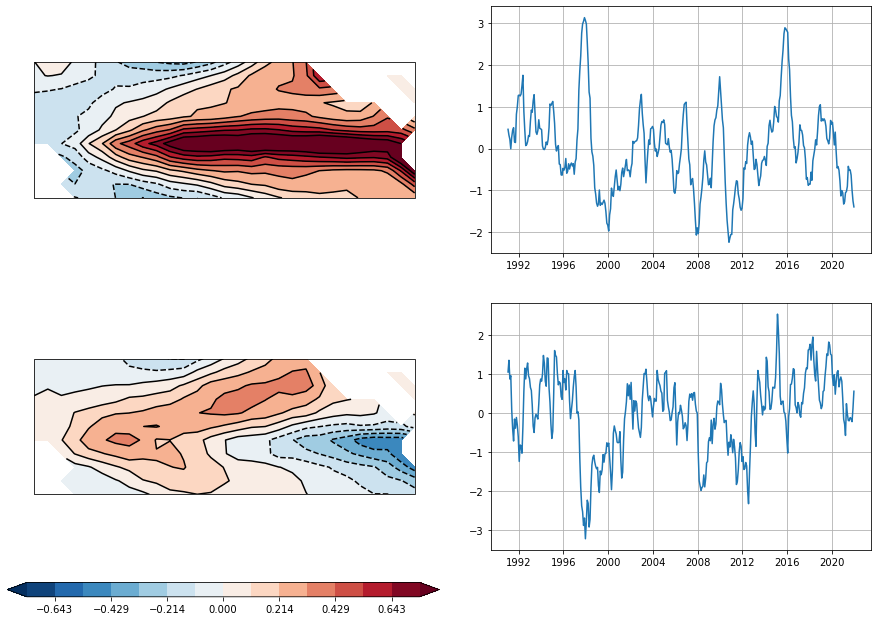

In [4]:
import sacpy as scp
import numpy as np
import matplotlib.pyplot as plt
# get data
sst = scp.load_sst()["sst"].loc[:, -20:40, 140:280]
ssta = scp.get_anom(sst)
# EOF
eof = scp.EOF(np.array(ssta))
eof.solve()
# get spartial pattern and pc
pc = eof.get_pc(npt=2)
pt = eof.get_pt(npt=2)

# plot
import cartopy.crs as ccrs
import sacpy.Map
lon , lat = np.array(ssta.lon) , np.array(ssta.lat)

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(221,projection=ccrs.PlateCarree(central_longitude=180))
m1 = ax.scontourf(lon,lat,pt[0,:,:],cmap='RdBu_r',levels=np.linspace(-0.75,0.75,15),extend="both")
ax.scontour(m1,colors="black")
#ax.init_map(ysmall=2.5)
# plt.colorbar(m1)
ax2 = fig.add_subplot(222)
ax2.plot(sst.time,pc[0])
ax2.grid()
ax3 = fig.add_subplot(223,projection=ccrs.PlateCarree(central_longitude=180))
m2 = ax3.scontourf(lon,lat,pt[1,:,:],cmap='RdBu_r',levels=np.linspace(-0.75,0.75,15),extend="both")
ax3.scontour(m2,colors="black")
#ax3.init_map(ysmall=2.5)
ax4 = fig.add_subplot(224)
ax4.plot(sst.time,pc[1])
ax4.grid()


cb_ax = fig.add_axes([0.1,0.06,0.4,0.02])
fig.colorbar(m1,cax=cb_ax,orientation="horizontal")
#plt.savefig("eof_ana.png",dpi=300)


# Analysis

Today all the analysis is done within the plotting cells!

# Load the data

In [5]:
# read sw netcdf file
idir = "/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p2f1/Amon/rsds/gn/v20230522/"
ds_sw = xr.open_dataset(idir+'rsds_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-055512.nc')

# read ts netcdf file
idir = "/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p2f1/Amon/ts/gn/v20230522/"
ds = xr.open_dataset(idir+'ts_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-055512.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


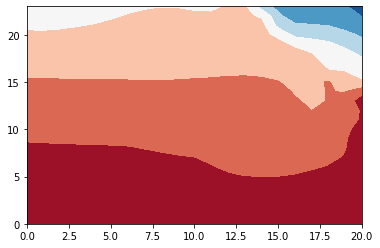

In [6]:
# select NEP region 2D
sst = ds.sel(lon=slice(210, 250), lat=slice(10, 40))
plt.contourf(sst.ts[0])

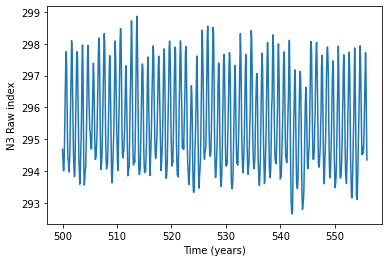

In [7]:
# select NEP region
sst = ds.sel(lon=slice(220, 250), lat=slice(10, 30))

nep = sst.ts.mean(dim=['lon', 'lat'])
time_frac = (ds.time.dt.year + (ds.time.dt.month - 1)/12).values

# plot N3 index against time
fig, ax = plt.subplots()
plt.plot(time_frac, nep)
ax.set_xlabel('Time (years)')
ax.set_ylabel('N3 Raw index')
plt.show()

In [8]:
lon_geotiff = sst.lon
lat_geotiff = sst.lat
z_geotiff = sst.ts[0]
print(lon_geotiff.shape)
print(lat_geotiff.shape)
print(z_geotiff.shape)

(16,)
(16,)
(16, 16)


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


[226.79046568 227.80173692 228.81300816 229.82427941 230.83555065
 231.84682189 232.85809314 233.86936438 234.88063562 235.89190686
 236.90317811 237.91444935 238.92572059 239.93699184 240.94826308
 241.95953432]
[14.48951326 15.22424483 15.95897639 16.69370796 17.42843952 18.16317109
 18.89790265 19.63263422 20.36736578 21.10209735 21.83682891 22.57156048
 23.30629204 24.04102361 24.77575517 25.51048674]
[298.5787667  297.73032333 296.542649   295.13337081 294.42595872
 294.06809696 293.87647838 293.77111062 293.77680096 293.84647218
 293.86634762 293.66888139 293.40649277 293.16152025 292.85687089
 292.46903699]


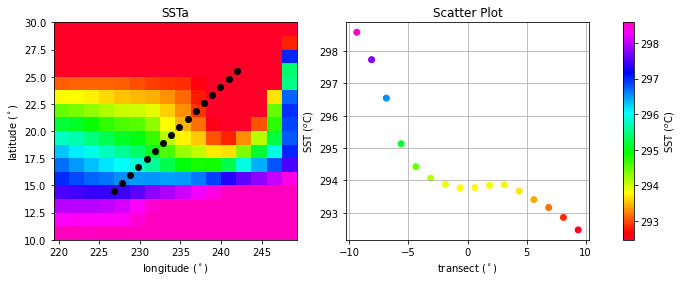

In [9]:
# Example usage
x = lon_geotiff.values # np.array([1.0, 2.0, 3.0])
y = lat_geotiff.values # np.array([4.0, 5.0, 6.0])
z = z_geotiff.values # np.array([[7.0, 8.0, 9.0], [10.0, 11.0, 12.0], [13.0, 14.0, 15.0]])
#lon_geotiff.to_netcdf('/scratch/p66/ars599/andrew2023/day5/x.nc')
#lat_geotiff.to_netcdf('/scratch/p66/ars599/andrew2023/day5/y.nc')
#z_geotiff.to_netcdf('/scratch/p66/ars599/andrew2023/day5/z.nc')

tempangles = np.pi/5
npoints = len(lon_geotiff)
(transect_pointsx, transect_pointsy, 
 transect_pointss, transect_pointsz) = get_transect(tempangles, npoints, x, y, z)

# --- plot ---
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
colormap = 'gist_rainbow'

# Create the contour plot in ax1
contour = ax1.pcolormesh(x, y, z, vmax=np.max(transect_pointsz), vmin=np.min(transect_pointsz), cmap=colormap)
ax1.scatter(transect_pointsx,transect_pointsy,c='k')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('SSTa')

# Create the scatter plot in ax2
scatter = ax2.scatter(transect_pointss,transect_pointsz,c=transect_pointsz, cmap=colormap)
ax2.set_title('Scatter Plot')
ax1.set_xlabel('longitude ($^\\circ$)')
ax1.set_ylabel('latitude ($^\\circ$)')
ax2.set_xlabel('transect ($^\\circ$)')
ax2.set_ylabel('SST ($^o$C)')
#ax2.set_xlim(transect_pointss[0],transect_pointss[-1])
ax2.grid()

# Add a color bar that is shared between the contour plot and scatter plot
cbar = fig.colorbar(contour, ax=[ax1, ax2], label='SST ($^o$C)')

print(transect_pointsx)
print(transect_pointsy)
print(transect_pointsz)

<H2>Now loop through the time</H2>

In [10]:
'''
3D
'''
ntime = len(sst.time)   # 732
nlat = len(transect_pointsy) # 24
nlon = len(transect_pointsx) # 21

# Create dummy lon, lat, and time arrays
lon = transect_pointsx # np.linspace(0, 360, nlon)
lat = transect_pointsy # np.linspace(-90, 90, nlat)
time = sst.time # np.arange(ntime)

# Create dummy SST data
sst_data = np.zeros((ntime, nlat, nlon))

# Create the xarray dataset
dummy_sst = xr.Dataset(
    {
        "sst": (("time", "lat", "lon"), sst_data),
    },
    coords={
        "lon": lon,
        "lat": lat,
        "time": time,
    },
)

# Optional: Assign attributes if needed
dummy_sst["sst"].attrs["units"] = "degrees Celsius"
dummy_sst

<xarray.Dataset>
Dimensions:  (time: 672, lat: 16, lon: 16)
Coordinates:
  * lon      (lon) float64 226.8 227.8 228.8 229.8 ... 238.9 239.9 240.9 242.0
  * lat      (lat) float64 14.49 15.22 15.96 16.69 ... 23.31 24.04 24.78 25.51
  * time     (time) object 0500-01-16 12:00:00 ... 0555-12-16 12:00:00
Data variables:
    sst      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [11]:
'''
2D
'''
ntime = len(sst.time)   # 732
nsec = len(transect_pointss) # 24

# Create dummy lon, lat, and time arrays
sec = transect_pointss # np.linspace(0, 360, nlon)
time = sst.time # np.arange(ntime)

# Create dummy SST data
sst_data = np.zeros((ntime, nsec))

# Create the xarray dataset
dummy_sst = xr.Dataset(
    {
        "sst": (("time", "sec"), sst_data),
    },
    coords={
        "sec": sec,
        "time": time,
    },
)

# Optional: Assign attributes if needed
dummy_sst["sst"].attrs["units"] = "degrees Celsius"
dummy_sst

<xarray.Dataset>
Dimensions:  (time: 672, sec: 16)
Coordinates:
  * sec      (sec) float64 -9.375 -8.125 -6.875 -5.625 ... 6.875 8.125 9.375
  * time     (time) object 0500-01-16 12:00:00 ... 0555-12-16 12:00:00
Data variables:
    sst      (time, sec) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [12]:
z_geotiff = sst.ts
tempangles = np.pi/5
npoints = len(lon_geotiff)

x = lon_geotiff.values # np.array([1.0, 2.0, 3.0])
y = lat_geotiff.values # np.array([4.0, 5.0, 6.0])


for i in range(ntime):
    z = z_geotiff[i].values  # Example data for z_geotiff, replace with your actual data

    (transect_pointsx, transect_pointsy, 
    transect_pointss, transect_pointsz) = get_transect(tempangles, npoints, x, y, z)
    dummy_sst["sst"][i] = transect_pointsz


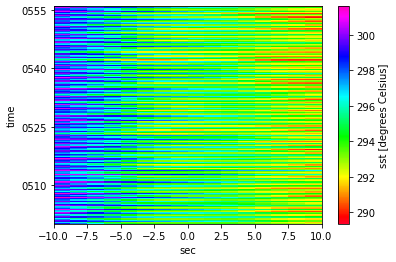

In [14]:
dummy_sst['sst'].plot(cmap=colormap)

sst2D_nep = dummy_sst["sst"]
sst2D_nep_clim = sst2D_nep.groupby("time.month").mean(dim="time")
sst2D_nep_anom = sst2D_nep.groupby("time.month") - sst2D_nep_clim


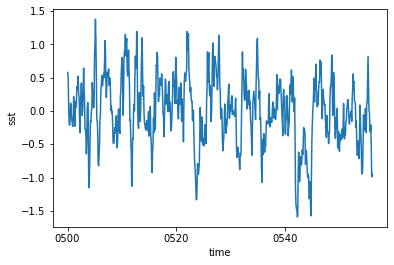

In [15]:
# Calculate the climatology as average over latitude and longitude for each time step
sst_nep = dummy_sst["sst"].mean(dim=["sec"])

# Calculate the climatology as average over months
nep_climatology = sst_nep.groupby("time.month").mean(dim="time")

# Calculate the anomaly as deviation from the climatology
nep_anomaly = sst_nep.groupby("time.month") - nep_climatology
nep_anomaly.plot()

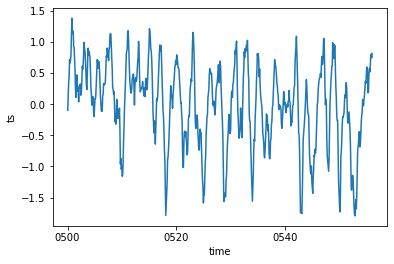

In [16]:
n3 = ds.ts.sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=["lat", "lon"])

# Calculate the climatology as average over months
n3_climatology = n3.groupby("time.month").mean(dim="time")

# Calculate the anomaly as deviation from the climatology
n3_anomaly = n3.groupby("time.month") - n3_climatology
n3_anomaly.plot()

<xarray.DataArray ()>
array(0.20091661)


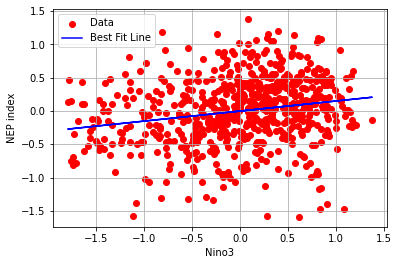

In [17]:
x = n3_anomaly
y = nep_anomaly
degree = 1  # Degree of the polynomial
coefficients = np.polyfit(x, y, degree)
best_fit_line = np.polyval(coefficients, x)
plt.scatter(x, y, color='red', label='Data')
plt.plot(x, best_fit_line, color='blue', label='Best Fit Line')
plt.legend()
plt.xlabel('Nino3')
plt.ylabel('NEP index')
correlation = xr.corr(x,y)
print(correlation)
plt.grid()

plt.show()



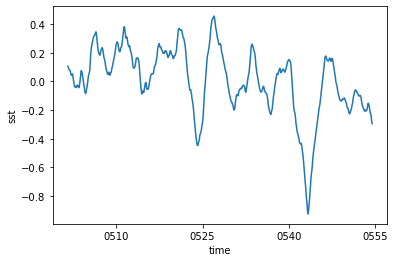

In [18]:
sst_nep_lat = dummy_sst["sst"].mean(dim=["sec"])
sst_nep_lat_clim = sst_nep_lat.groupby("time.month").mean(dim="time")
sst_nep_lat_anom = sst_nep_lat.groupby("time.month") - sst_nep_lat_clim

fig = plt.gcf()
ax1 = plt.subplot(111)
window_size = 36
sst_nep_lat_anom_rolling = sst_nep_lat_anom.rolling(time=window_size, center=True).mean()
sst_nep_lat_anom_rolling.plot()



# FFT Spectrum

In [19]:
def normalize(v):
    std = v.std()
    return v / std

In [20]:
from scipy import signal
time_frac = (n3.time.dt.year + (n3.time.dt.month - 1)/12).values

fs = 1.0 / np.mean(np.diff(time_frac))  # Calculate the sampling frequency

# Compute the power spectral density using Welch's method
f1, p1 = signal.welch(normalize(n3_anomaly), fs=fs)
f2, p2 = signal.welch(normalize(nep_anomaly), fs=fs)


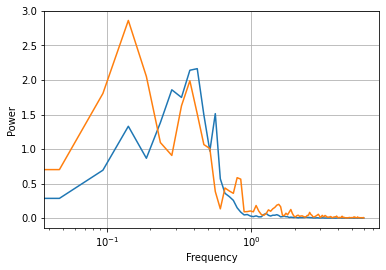

In [21]:
plt.plot(f1, p1, f2, p2)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid()
plt.show()


# Auto Correlation

1343


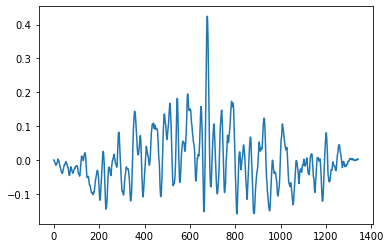

In [22]:
'''
lead lag corr
https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html
'''
npts = ntime
x = time_frac
y1 = normalize(n3_anomaly)
y2 = normalize(nep_anomaly)

lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
#ccor = ccov / (npts * y1.std() * y2.std())
ccor = ccov / npts
plt.plot(ccor)
print(len(ccor))

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


max correlation is at lag 6


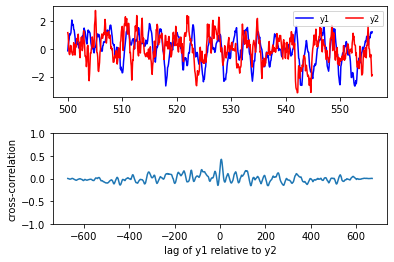

In [23]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='y1')
ax.plot(x, y2, 'r', label='y2')
#ax.set_ylim(-1, 1)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylim(-1., 1.)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)

<H1> Lead and Lag corr. reg between NEP & SST</H1>

In [24]:
'''

https://climate.usu.edu/people/yoshi/pyclm101/monthly.html

'''
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

import os
from datetime import datetime

import geocat.viz.util as gvutil
#from geocat.viz import cmaps as gvcmaps


In [25]:
rninoSD = nep_anomaly

sst_raw = ds.ts.sel(lon=slice(140, 270), lat=slice(-40, 40))
sst_clim = sst_raw.groupby("time.month").mean(dim="time")
sst_anom = sst_raw.groupby("time.month") - sst_clim


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


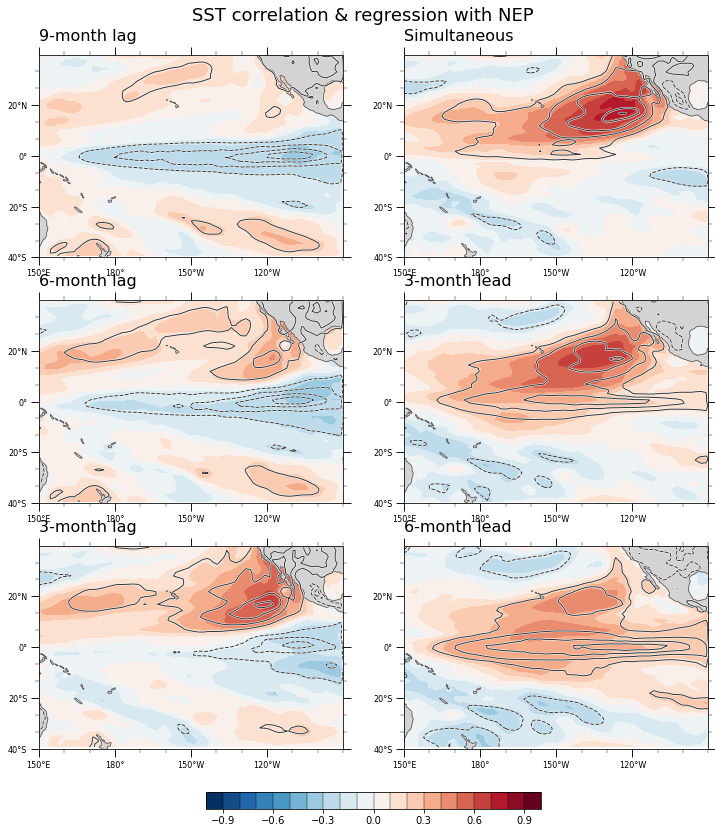

In [26]:
# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
ranm = sst_anom.rolling(time=7, center=True).mean('time')
#rdanm = ranm # detrend_dim(ranm,'time',1)
rdanm = detrend_dim(ranm,'time',1)

# -- Correlation & Regression
#ranm = sst_anom.rolling(time=7, center=True).mean('time')

# Leading
corM12 = xr.corr(rninoSD, rdanm.shift(time=-6), dim="time")
regM12 = xr.cov( rninoSD, rdanm.shift(time=-6), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM6 = xr.corr(rninoSD, rdanm.shift(time=-3), dim="time")
regM6 = xr.cov( rninoSD, rdanm.shift(time=-3), dim="time")/rninoSD.var(dim='time',skipna=True).values

# simultaneous
cor0 = xr.corr(rninoSD, rdanm, dim="time")
reg0 = xr.cov(rninoSD, rdanm, dim="time")/rninoSD.var(dim='time',skipna=True).values

# Laging
corP6 = xr.corr(rninoSD, rdanm.shift(time=3), dim="time")
regP6 = xr.cov( rninoSD, rdanm.shift(time=3), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP12 = xr.corr(rninoSD, rdanm.shift(time=6), dim="time")
regP12 = xr.cov( rninoSD, rdanm.shift(time=6), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP18 = xr.corr(rninoSD, rdanm.shift(time=9), dim="time")
regP18 = xr.cov( rninoSD, rdanm.shift(time=9), dim="time")/rninoSD.var(dim='time',skipna=True).values


# -- figure plot

def makefig(cor, reg,title, grid_space):
  # Fix the artifact of not-shown-data around 0 and 360-degree longitudes
  cor = gvutil.xr_add_cyclic_longitudes(cor, 'lon')
  reg = gvutil.xr_add_cyclic_longitudes(reg, 'lon')
  # Generate axes using Cartopy to draw coastlines
  ax = fig.add_subplot(grid_space,
          projection=ccrs.PlateCarree(central_longitude=210))
  ax.coastlines(linewidth=0.5, alpha=0.6)
  
  # Use geocat.viz.util convenience function to set axes limits & tick values
  gvutil.set_axes_limits_and_ticks(ax,
                                 xlim=(-60, 60),
                                 ylim=(-40, 40),
                                 xticks=np.arange(-60, 60, 30),
                                 yticks=np.arange(-40, 40, 20))
  
  # Use geocat.viz.util convenience function to add minor and major tick lines
  gvutil.add_major_minor_ticks(ax, labelsize=8)
  
  # Use geocat.viz.util convenience function to make latitude, longitude tick labels
  gvutil.add_lat_lon_ticklabels(ax)
  
  # Define dictionary for kwargs
  kwargs = dict(
    vmin = -1.0,
    vmax = 1.0,
    levels = 21,
    cmap='RdBu_r',   
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
  )
  
  # Contouf-plot U data (for filled contours)
  fillplot = cor.plot.contourf(ax=ax,  **kwargs)

  # Draw map features on top of filled contour
  ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
  ax.add_feature(cfeature.COASTLINE, edgecolor='gray', linewidth=0.5, zorder=1)
  
  # Plot line contours
  # Specify contour levels excluding 0
  delc=0.2
  levels = np.arange(-3, 0, delc)
  levels = np.append(levels, np.arange(delc, 3, delc))
  
  rad = reg.plot.contour(ax=ax,
                  colors='black',
                  extend="both",
                  alpha=0.8,
                  linewidths=1.0,
                  add_labels=False,
                  levels=levels,
                  transform=ccrs.PlateCarree())
#  ax.clabel(rad, levels, fmt='%1.1f',  inline=True, colors='black', fontsize=8)
  pe = [PathEffects.withStroke(linewidth=2.0, foreground="w")]
  plt.setp(rad.collections, path_effects=pe)
  
  # Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
  gvutil.set_titles_and_labels(ax,
                             lefttitle=title,
                             lefttitlefontsize=16,
                             righttitle='',
                             righttitlefontsize=16,
                             xlabel="",
                             ylabel="")

  return ax, fillplot

# Show the plot

fig = plt.figure(figsize=(12, 16))
#grid = fig.add_gridspec(ncols=2, nrows=3)
grid = fig.add_gridspec(ncols=2, nrows=3, hspace=0.20)


ax1, fill1 = makefig(corP18,regP18,'9-month lag', grid[0,0])
ax2, fill2 = makefig(corP12,regP12,'6-month lag', grid[1,0])
ax3, fill3 = makefig(corP6,regP6,'3-month lag', grid[2,0])
ax4, fill4 = makefig(cor0,reg0,'Simultaneous', grid[0,1])
ax5, fill5 = makefig(corM6,regM6,'3-month lead', grid[1,1])
ax6, fill6 = makefig(corM12,regM12,'6-month lead', grid[2,1])

fig.colorbar(fill6,
                 ax=[ax1, ax2, ax3, ax4, ax5, ax6],
#                 ticks=np.linspace(-5, 5, 11),
                 drawedges=True,
                 orientation='horizontal',
                 shrink=0.5,
                 extend="both",
                 pad=0.05,
                 extendfrac='auto',
                 extendrect=True)
  
fig.suptitle('SST correlation & regression with NEP', fontsize=18, y=0.92)

plt.draw()
#plt.savefig(fnFIG+".png")
#plt.savefig(fnFIG+".pdf")
#plt.savefig(fnFIG+".eps", format='eps')

# NEP induced by Ninio3

In [29]:
n3_anomaly.to_netcdf('/scratch/p66/ars599/andrew2023/day5/n3_anomaly.nc')
nep_anomaly.to_netcdf('/scratch/p66/ars599/andrew2023/day5/nep_anomaly.nc')
sst2D_nep_anom.to_netcdf('/scratch/p66/ars599/andrew2023/day5/sst2D_nep_anom.nc')

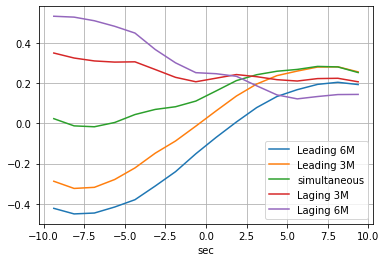

In [30]:
rninoSD = n3_anomaly
# -- Running mean
ranm = sst2D_nep_anom.rolling(time=7, center=True).mean('time')
rdanm = detrend_dim(ranm,'time',1)

cor0 = xr.corr(rninoSD, rdanm, dim="time")

# Leading
corM6 = xr.corr(rninoSD, rdanm.shift(time=-6), dim="time")
corM3 = xr.corr(rninoSD, rdanm.shift(time=-3), dim="time")
# simultaneous
cor0 = xr.corr(rninoSD, rdanm, dim="time")
# Laging
corP3 = xr.corr(rninoSD, rdanm.shift(time=3), dim="time")
corP6 = xr.corr(rninoSD, rdanm.shift(time=6), dim="time")

corM6.plot(label='Leading 6M')
corM3.plot(label='Leading 3M')
cor0.plot(label='simultaneous')
corP3.plot(label='Laging 3M')
corP6.plot(label='Laging 6M')
plt.grid()
plt.legend()

### The evolution and the relationship between Nino3 and NEP
##### Positive corr. -> heat source -> peaks at north
##### Then move to south within 3 months
##### N3 & NEP Peaks Simultaneously
##### A local osilation !!???

<H1> Lead and Lag corr. reg between NEP & SW</H1>

In [31]:
sw_raw = ds_sw.rsds.sel(lon=slice(140, 270), lat=slice(-40, 40))
sw_clim = sw_raw.groupby("time.month").mean(dim="time")
sw_anom = sw_raw.groupby("time.month") - sw_clim

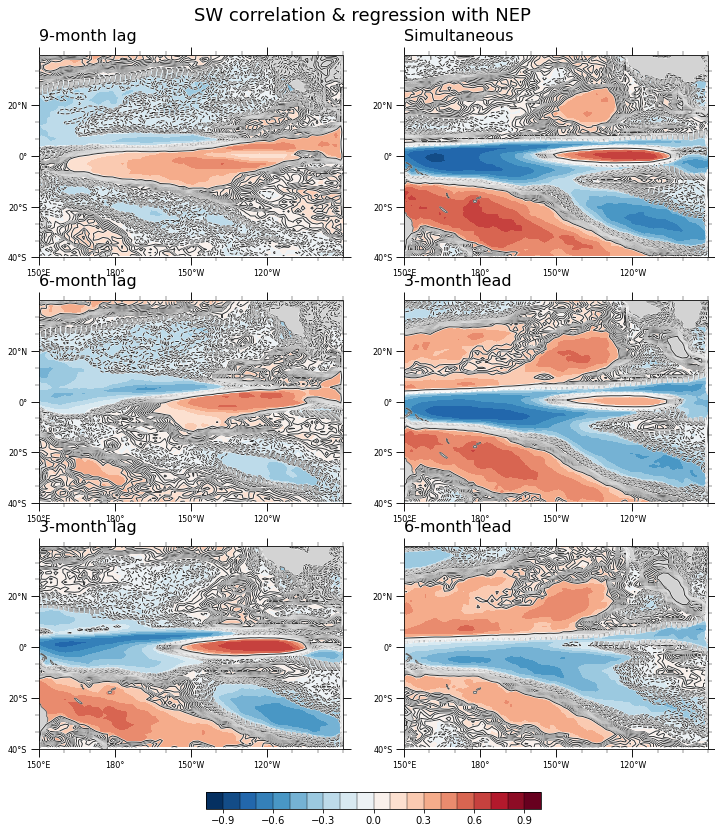

In [32]:
# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
ranm = sw_anom.rolling(time=7, center=True).mean('time')
rdanm = detrend_dim(ranm,'time',1)

# -- Correlation & Regression
#ranm = sst_anom.rolling(time=7, center=True).mean('time')

# Leading
corM12 = xr.corr(rninoSD, rdanm.shift(time=-6), dim="time")
regM12 = xr.cov( rninoSD, rdanm.shift(time=-6), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM6 = xr.corr(rninoSD, rdanm.shift(time=-3), dim="time")
regM6 = xr.cov( rninoSD, rdanm.shift(time=-3), dim="time")/rninoSD.var(dim='time',skipna=True).values

# simultaneous
cor0 = xr.corr(rninoSD, rdanm, dim="time")
reg0 = xr.cov(rninoSD, rdanm, dim="time")/rninoSD.var(dim='time',skipna=True).values

# Laging
corP6 = xr.corr(rninoSD, rdanm.shift(time=3), dim="time")
regP6 = xr.cov( rninoSD, rdanm.shift(time=3), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP12 = xr.corr(rninoSD, rdanm.shift(time=6), dim="time")
regP12 = xr.cov( rninoSD, rdanm.shift(time=6), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP18 = xr.corr(rninoSD, rdanm.shift(time=9), dim="time")
regP18 = xr.cov( rninoSD, rdanm.shift(time=9), dim="time")/rninoSD.var(dim='time',skipna=True).values


# -- figure plot

def makefig(cor, reg,title, grid_space):
  # Fix the artifact of not-shown-data around 0 and 360-degree longitudes
  cor = gvutil.xr_add_cyclic_longitudes(cor, 'lon')
  reg = gvutil.xr_add_cyclic_longitudes(reg, 'lon')
  # Generate axes using Cartopy to draw coastlines
  ax = fig.add_subplot(grid_space,
          projection=ccrs.PlateCarree(central_longitude=210))
  ax.coastlines(linewidth=0.5, alpha=0.6)
  
  # Use geocat.viz.util convenience function to set axes limits & tick values
  gvutil.set_axes_limits_and_ticks(ax,
                                 xlim=(-60, 60),
                                 ylim=(-40, 40),
                                 xticks=np.arange(-60, 60, 30),
                                 yticks=np.arange(-40, 40, 20))
  
  # Use geocat.viz.util convenience function to add minor and major tick lines
  gvutil.add_major_minor_ticks(ax, labelsize=8)
  
  # Use geocat.viz.util convenience function to make latitude, longitude tick labels
  gvutil.add_lat_lon_ticklabels(ax)
  
  # Define dictionary for kwargs
  kwargs = dict(
    vmin = -1.0,
    vmax = 1.0,
    levels = 21,
    cmap='RdBu_r',   
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
  )
  
  # Contouf-plot U data (for filled contours)
  fillplot = cor.plot.contourf(ax=ax,  **kwargs)

  # Draw map features on top of filled contour
  ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
  ax.add_feature(cfeature.COASTLINE, edgecolor='gray', linewidth=0.5, zorder=1)
  
  # Plot line contours
  # Specify contour levels excluding 0
  delc=0.2
  levels = np.arange(-3, 0, delc)
  levels = np.append(levels, np.arange(delc, 3, delc))
  
  rad = reg.plot.contour(ax=ax,
                  colors='black',
                  extend="both",
                  alpha=0.8,
                  linewidths=1.0,
                  add_labels=False,
                  levels=levels,
                  transform=ccrs.PlateCarree())
#  ax.clabel(rad, levels, fmt='%1.1f',  inline=True, colors='black', fontsize=8)
  pe = [PathEffects.withStroke(linewidth=2.0, foreground="w")]
  plt.setp(rad.collections, path_effects=pe)
  
  # Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
  gvutil.set_titles_and_labels(ax,
                             lefttitle=title,
                             lefttitlefontsize=16,
                             righttitle='',
                             righttitlefontsize=16,
                             xlabel="",
                             ylabel="")

  return ax, fillplot

# Show the plot

fig = plt.figure(figsize=(12, 16))
#grid = fig.add_gridspec(ncols=2, nrows=3)
grid = fig.add_gridspec(ncols=2, nrows=3, hspace=0.20)


ax1, fill1 = makefig(corP18,regP18,'9-month lag', grid[0,0])
ax2, fill2 = makefig(corP12,regP12,'6-month lag', grid[1,0])
ax3, fill3 = makefig(corP6,regP6,'3-month lag', grid[2,0])
ax4, fill4 = makefig(cor0,reg0,'Simultaneous', grid[0,1])
ax5, fill5 = makefig(corM6,regM6,'3-month lead', grid[1,1])
ax6, fill6 = makefig(corM12,regM12,'6-month lead', grid[2,1])

fig.colorbar(fill6,
                 ax=[ax1, ax2, ax3, ax4, ax5, ax6],
#                 ticks=np.linspace(-5, 5, 11),
                 drawedges=True,
                 orientation='horizontal',
                 shrink=0.5,
                 extend="both",
                 pad=0.05,
                 extendfrac='auto',
                 extendrect=True)
  
fig.suptitle('SW correlation & regression with NEP', fontsize=18, y=0.92)

plt.draw()
#plt.savefig(fnFIG+".png")
#plt.savefig(fnFIG+".pdf")
#plt.savefig(fnFIG+".eps", format='eps')